## Домашнее Задание по Теории Графов № 1
#### Стоева Валерия, 154 группа

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 

Все схемы метро я брала с репозитория https://github.com/tupinek?tab=repositories 

   Так как я использую nx.Graph(), то мультиребер в нем нет. Также в наших схемах нет изолированных вершин, так как никому не нужна станция, с которой нельзя никуда уехать.
    
   Значит нам осталось только соединить вершины станций, которые соединены меджу собой переходами

In [2]:
def parse_and_preprocess_graph(xmlfile):
    G = nx.Graph()
    parsed_xml = ET.parse(xmlfile)

    # adding vertices
    for entity in parsed_xml.iter():
        items_dict = dict(entity.items())
        if entity.tag == 'station':
            G.add_node(items_dict['id'] , attrs=items_dict)

    # adding edges
    for entity in parsed_xml.iter():
        items_dict = dict(entity.items())
        if entity.tag == 'station':
            for neighbour in items_dict['link'].split(','):
                G.add_edge(items_dict['id'] , neighbour)
    
    # combine connected stations
    G_old = G.copy()
    for node, spec in G_old.nodes.items():
        if node in G.nodes and 'other_link' in spec['attrs']:
            connected = (node,) + tuple(
                map(
                    lambda connection: connection.split(':')[1],
                    spec['attrs']['other_link'].split(',')
                )
            )
            new_node = '+'.join(connected)
            G.add_node(new_node)
            edges_to_add = [] # handling "RuntimeError: dictionary changed size during iteration"
            for v1, v2 in G.edges:
                if v1 in connected:
                    edges_to_add.append((new_node, v2))
                elif v2 in connected:
                    edges_to_add.append((v1, new_node))
            for e in edges_to_add:
                G.add_edge(*e)
            for v in connected:
                G.remove_node(v)
    return G

In [3]:
def draw_graph(G):
    options = {
        'node_color': 'black',
        'node_size': 10,
        'line_color': 'grey',
        'width': 0.3,
        'with_labels': True,
        'font_size': 10,
    }
    plt.figure(3,figsize=(12,12)) 
    nx.draw(G,pos=nx.spring_layout(G),  **options)

Для анализа было выбрано 3 смемы метро: 

    1) Петербу́ргский метрополите́н: 5 линий, 69 станций
    2) Ки́евский метрополите́н: 3 линии, 52 станции
    3) Екатеринбу́ргский метрополите́н: 1 линия, 9 станций
    
Считываем и обрабатываем графы и выводим их схемы на экран

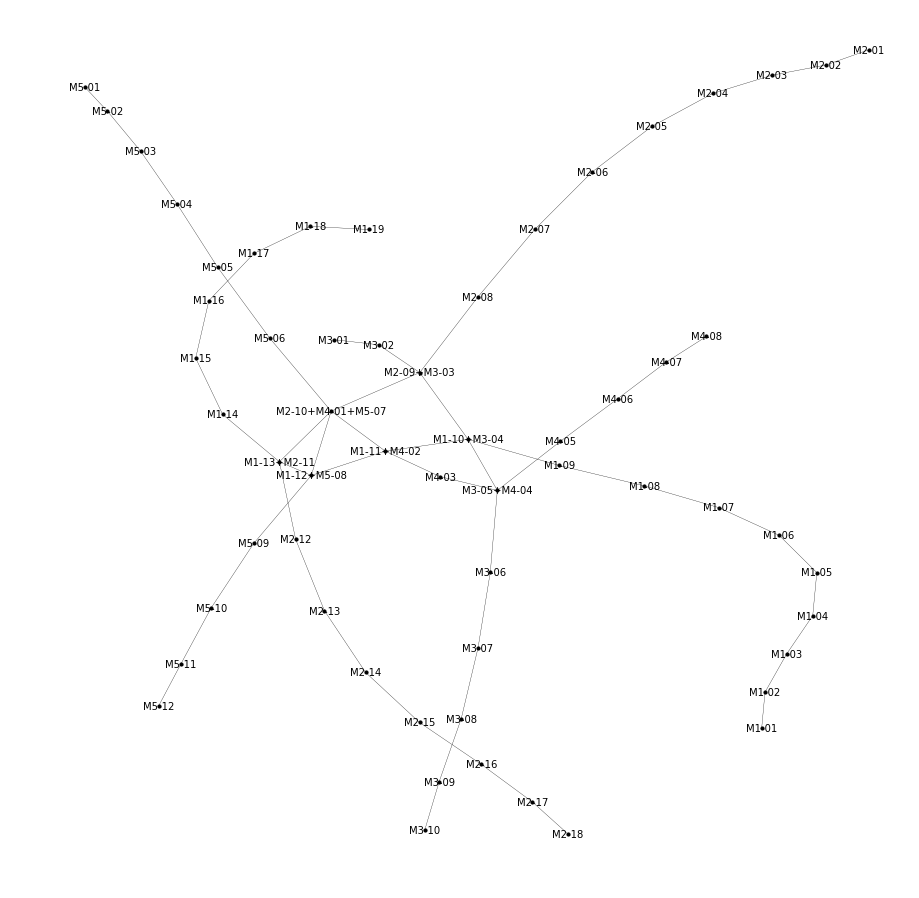

In [6]:
SP = parse_and_preprocess_graph('saint_petersburg-map.xml')
draw_graph(SP)

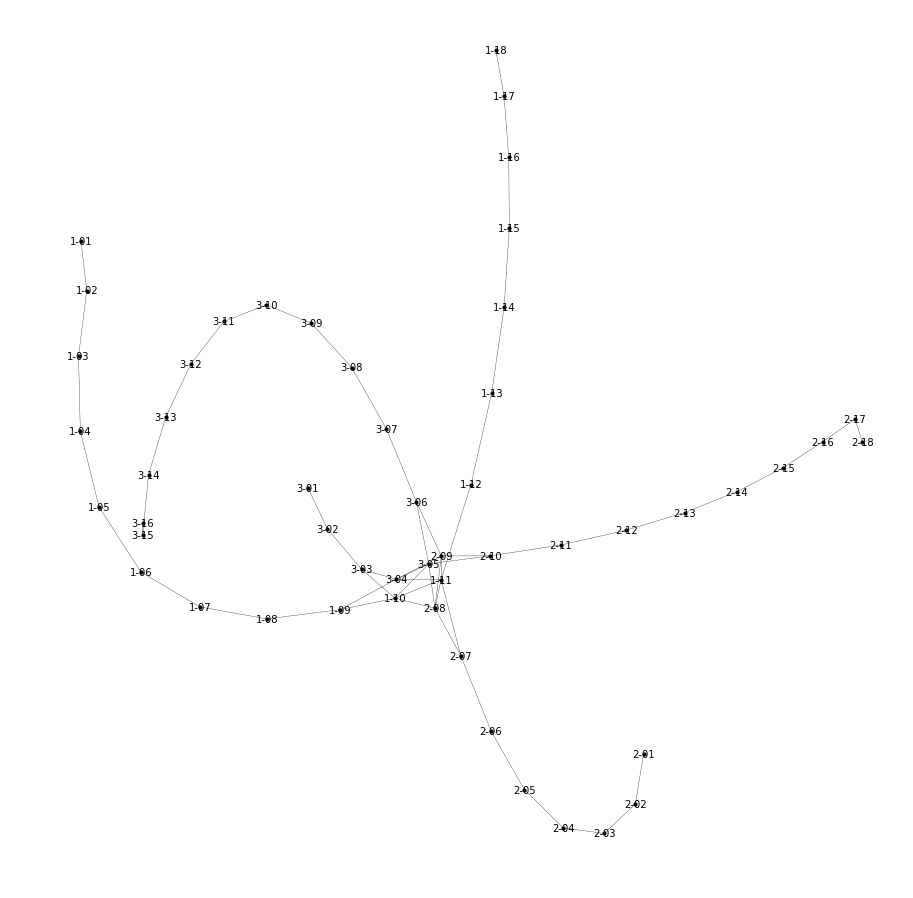

In [8]:
Kiev = parse_and_preprocess_graph('kiev-map.xml')
draw_graph(Kiev)

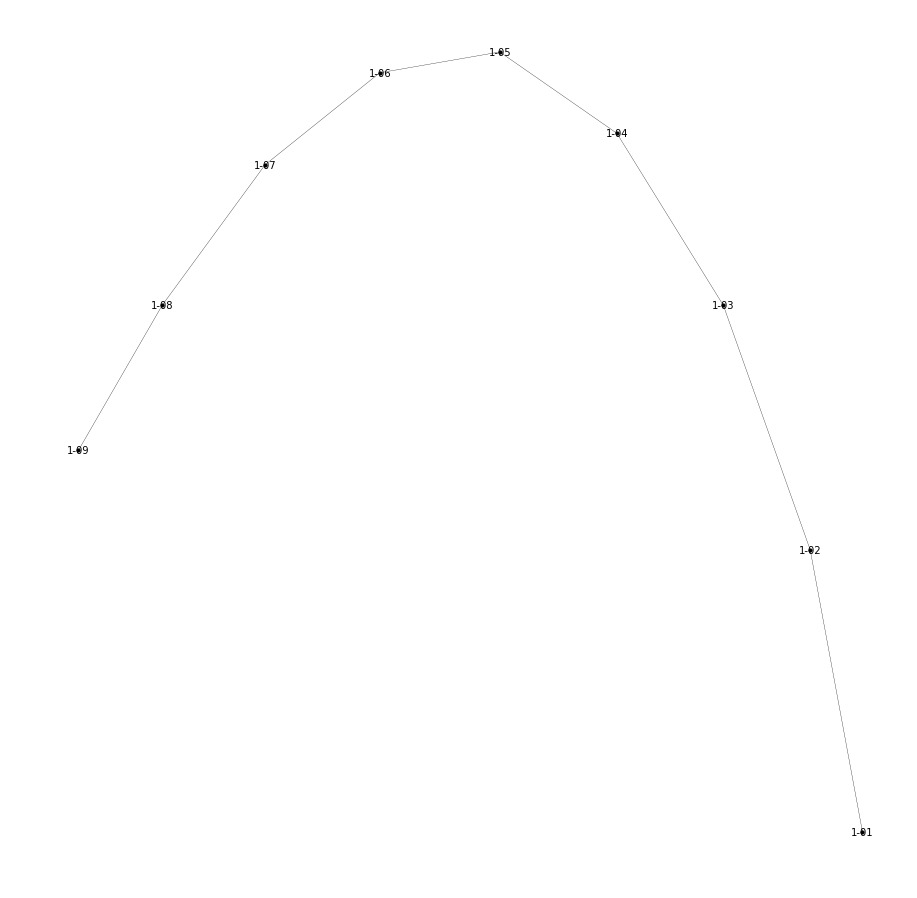

In [9]:
Ekaterin = parse_and_preprocess_graph('yekaterinburg-map.xml')
draw_graph(Ekaterin)

### 3. Проверка на изоморфность алгоритмом VF2
Проверим на изоморфность Метро Питера и Киева методом VF2, реализованном в networkx.algorithms 

In [77]:
from networkx.algorithms import isomorphism
SP_Kiev = isomorphism.GraphMatcher(SP, Kiev)
SP_Kiev.is_isomorphic()

False

### Проверка на изоморфность алгоритмом BLISS
Проверим на изоморфность Метро Питера и Киева методом  BLISS, реализованном в igraph. 
ДЛя этого сначала приведем наши графы к подходящему виду, то есть из networkx в igraph

In [78]:
import igraph as ig
g1 = ig.Graph.Adjacency((nx.to_numpy_matrix(Kiev) > 0).tolist())
g2 = ig.Graph.Adjacency((nx.to_numpy_matrix(SP) > 0).tolist())
g1.isomorphic_bliss(g2)

False

Как мы видим, обо метода дают один и тот же результат

### 4. В большом графе указать какой-либо подграф, изоморфный маленькому
Проверяем подрграфы Питерского метро на изоморфность с Екатеринбургским метрополитеном

In [80]:
ism = isomorphism.GraphMatcher(SP, Ekaterin)
for subgraph in ism.subgraph_isomorphisms_iter():
    print(subgraph)

{'M1-01': '1-01', 'M1-02': '1-02', 'M1-03': '1-03', 'M1-04': '1-04', 'M1-05': '1-05', 'M1-06': '1-06', 'M1-07': '1-07', 'M1-08': '1-08', 'M1-09': '1-09'}
{'M1-02': '1-01', 'M1-03': '1-02', 'M1-04': '1-03', 'M1-05': '1-04', 'M1-06': '1-05', 'M1-07': '1-06', 'M1-08': '1-07', 'M1-09': '1-08', 'M1-10+M3-04': '1-09'}
{'M1-03': '1-01', 'M1-04': '1-02', 'M1-05': '1-03', 'M1-06': '1-04', 'M1-07': '1-05', 'M1-08': '1-06', 'M1-09': '1-07', 'M1-10+M3-04': '1-08', 'M3-05+M4-04': '1-09'}
{'M1-03': '1-01', 'M1-04': '1-02', 'M1-05': '1-03', 'M1-06': '1-04', 'M1-07': '1-05', 'M1-08': '1-06', 'M1-09': '1-07', 'M1-10+M3-04': '1-08', 'M2-09+M3-03': '1-09'}
{'M1-03': '1-01', 'M1-04': '1-02', 'M1-05': '1-03', 'M1-06': '1-04', 'M1-07': '1-05', 'M1-08': '1-06', 'M1-09': '1-07', 'M1-10+M3-04': '1-08', 'M1-11+M4-02': '1-09'}
{'M1-04': '1-01', 'M1-05': '1-02', 'M1-06': '1-03', 'M1-07': '1-04', 'M1-08': '1-05', 'M1-09': '1-06', 'M1-10+M3-04': '1-07', 'M3-05+M4-04': '1-08', 'M4-05': '1-09'}
{'M1-04': '1-01', 'M1-

{'M3-08': '1-01', 'M3-07': '1-02', 'M3-06': '1-03', 'M3-05+M4-04': '1-04', 'M1-10+M3-04': '1-05', 'M2-09+M3-03': '1-06', 'M2-10+M4-01+M5-07': '1-07', 'M5-06': '1-08', 'M5-05': '1-09'}
{'M3-08': '1-01', 'M3-07': '1-02', 'M3-06': '1-03', 'M3-05+M4-04': '1-04', 'M1-10+M3-04': '1-05', 'M2-09+M3-03': '1-06', 'M2-10+M4-01+M5-07': '1-07', 'M1-13+M2-11': '1-08', 'M1-14': '1-09'}
{'M3-08': '1-01', 'M3-07': '1-02', 'M3-06': '1-03', 'M3-05+M4-04': '1-04', 'M1-10+M3-04': '1-05', 'M2-09+M3-03': '1-06', 'M2-10+M4-01+M5-07': '1-07', 'M1-13+M2-11': '1-08', 'M2-12': '1-09'}
{'M3-08': '1-01', 'M3-07': '1-02', 'M3-06': '1-03', 'M3-05+M4-04': '1-04', 'M4-03': '1-05', 'M1-11+M4-02': '1-06', 'M1-12+M5-08': '1-07', 'M5-09': '1-08', 'M5-10': '1-09'}
{'M3-08': '1-01', 'M3-07': '1-02', 'M3-06': '1-03', 'M3-05+M4-04': '1-04', 'M4-03': '1-05', 'M1-11+M4-02': '1-06', 'M1-12+M5-08': '1-07', 'M1-13+M2-11': '1-08', 'M1-14': '1-09'}
{'M3-08': '1-01', 'M3-07': '1-02', 'M3-06': '1-03', 'M3-05+M4-04': '1-04', 'M4-03': '1

{'M2-10+M4-01+M5-07': '1-01', 'M2-09+M3-03': '1-02', 'M1-10+M3-04': '1-03', 'M3-05+M4-04': '1-04', 'M3-06': '1-05', 'M3-07': '1-06', 'M3-08': '1-07', 'M3-09': '1-08', 'M3-10': '1-09'}
{'M2-10+M4-01+M5-07': '1-01', 'M2-09+M3-03': '1-02', 'M1-10+M3-04': '1-03', 'M1-09': '1-04', 'M1-08': '1-05', 'M1-07': '1-06', 'M1-06': '1-07', 'M1-05': '1-08', 'M1-04': '1-09'}
{'M2-10+M4-01+M5-07': '1-01', 'M1-13+M2-11': '1-02', 'M2-12': '1-03', 'M2-13': '1-04', 'M2-14': '1-05', 'M2-15': '1-06', 'M2-16': '1-07', 'M2-17': '1-08', 'M2-18': '1-09'}
{'M3-05+M4-04': '1-01', 'M1-10+M3-04': '1-02', 'M1-11+M4-02': '1-03', 'M1-12+M5-08': '1-04', 'M1-13+M2-11': '1-05', 'M1-14': '1-06', 'M1-15': '1-07', 'M1-16': '1-08', 'M1-17': '1-09'}
{'M3-05+M4-04': '1-01', 'M1-10+M3-04': '1-02', 'M1-11+M4-02': '1-03', 'M1-12+M5-08': '1-04', 'M1-13+M2-11': '1-05', 'M2-12': '1-06', 'M2-13': '1-07', 'M2-14': '1-08', 'M2-15': '1-09'}
{'M3-05+M4-04': '1-01', 'M1-10+M3-04': '1-02', 'M1-11+M4-02': '1-03', 'M2-10+M4-01+M5-07': '1-04',

Укажем явно один из подграфов

In [81]:
for elem in subgraph:
    print(subgraph[elem] , ':', elem)

1-01 : M3-05+M4-04
1-02 : M4-03
1-03 : M1-11+M4-02
1-04 : M2-10+M4-01+M5-07
1-05 : M1-13+M2-11
1-06 : M2-12
1-07 : M2-13
1-08 : M2-14
1-09 : M2-15
